In [41]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import string
import pickle

%matplotlib inline
#set column widths t
pd.set_option('display.max_colwidth', -1)

In [2]:
#import data (Thanks to Jen and team for allowing access to the dataset!)
raw = pd.read_csv('/Users/randy/Downloads/Online Harassment Dataset/onlineHarassmentDataset.tdf',
                 sep='\t', lineterminator='\r',header = 'infer', encoding='latin-1')

In [3]:
#check the first few rows. Note that there are a bunch of NaN columns
raw.head(3)

,ID,Code,Tweet,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her McJob.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,H,1948Army of England helped the Jews to occupy Palestine.After that the Jews killed thousands of Englishmen and returned to England as dogs1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,H,"Dutch Leader Says Europe to collapse In 6 Weeks thnks > @BillGates, @GeorgeSoros, & @FWD_us #AltRight #WhiteGenocide https: / /t.co /rl1mh82jda",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#pull only the Code and Tweet columns
data = raw[['Code','Tweet']]

In [5]:
data['Tweet'] = data['Tweet'].str.lower()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
regex_queries = [
                 '@([A-Za-z0-9_]+)', #Usernames
                'rt\s:\s', #Retweets
                 '(https?:\s?\/\s?\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?' # Hyperlinks
                ]

In [7]:
data['Tweet'].replace(regex_queries,'',regex = True, inplace = True)

/Users/randy/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# Clean the Data (Version 1)

https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1

In [8]:
#check the dimensions
data.shape

(20360, 2)

In [9]:
#check the first few rows
data.head(3)

,Code,Tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide"


In [10]:
raw.head(3)

,ID,Code,Tweet,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,H,@Grumpy_P_Sloth @deanesmay feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her McJob.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,H,1948Army of England helped the Jews to occupy Palestine.After that the Jews killed thousands of Englishmen and returned to England as dogs1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,H,"Dutch Leader Says Europe to collapse In 6 Weeks thnks > @BillGates, @GeorgeSoros, & @FWD_us #AltRight #WhiteGenocide https: / /t.co /rl1mh82jda",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#check that for each value of Code has a value in Tweet
assert data['Code'].isnull().count() == len(data['Tweet'])

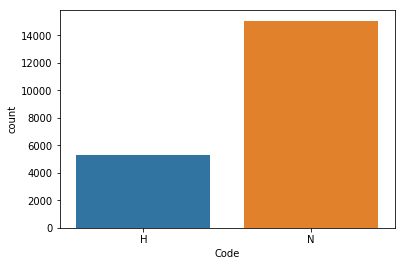

In [12]:
#visualize harassment vs non-harassment cases
sns.countplot(x = 'Code', data=data)

In [13]:
#lowercase all strings
data['Tweet'] = data['Tweet'].str.lower()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
s = "some\x00string. with\x15 funny characters"

printable = set(string.printable)
filter(lambda x: x in printable, s)


(-0.5, 399.5, 199.5, -0.5)

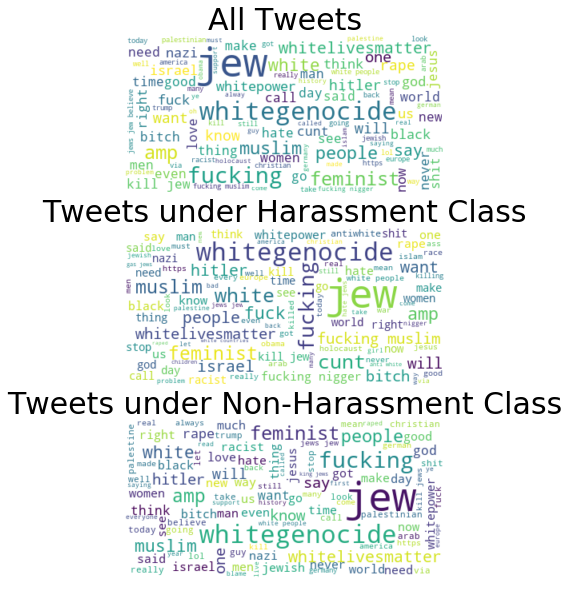

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with one review:
df_H = data[data['Code']=='H']
df_NH = data[data['Code']=='N']
tweet_All = " ".join(review for review in data.Tweet)
tweet_H = " ".join(review for review in df_H.Tweet)
tweet_NH = " ".join(review for review in df_NH.Tweet)

fig, ax = plt.subplots(3, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_H = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_H)
wordcloud_NH = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NH)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_H, interpolation='bilinear')
ax[1].set_title('Tweets under Harassment Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_NH, interpolation='bilinear')
ax[2].set_title('Tweets under Non-Harassment Class',fontsize=30)
ax[2].axis('off')

In [16]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [17]:
#remove non-ascii characters
def remove_non_ascii(text):
    text  = "".join([char for char in text if char in string.printable])
    text = re.sub('[0-9]+', '', text)
    return text

data['non_ascii_tweet'] = data['Tweet'].apply(lambda x: remove_non_ascii(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today ."
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory


In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
#remove the punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['no_punct_tweet'] = data['non_ascii_tweet'].apply(lambda x: remove_punct(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet,no_punct_tweet
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory


In [20]:
#tokenize the data
def tokenization(text):
    text = re.split('\W+', text)
    return text

data['Tweet_tokenized'] = data['no_punct_tweet'].apply(lambda x: tokenization(x.lower()))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]"


In [21]:
#remove STOPWORDS
stopword = nltk.corpus.stopwords.words('english')
#stopword.extend(['yr', 'year', 'woman', 'man', 'girl','boy','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
#               'treatment', 'associated', 'patients', 'may','day', 'case','old'])


In [22]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data['Tweet_nonstop'] = data['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
data.head(5)

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]"


In [23]:
#Stemming and Lammitization
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

data['Tweet_stemmed'] = data['Tweet_nonstop'].apply(lambda x: stemming(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]","[, feminist, argu, rais, minimum, wage, caus, women, studi, major, need, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]","[armi, england, help, jew, occupi, palestineaft, jew, kill, thousand, englishmen, return, england, dog]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, say, europ, collaps, week, thnk, altright, whitegenocid, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]","[next, day, roman, jew, watev, like, aye, fuck, nigga, jesu, ride, ass, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]","[hitler, invit, jew, smoke, session, wasnt, ga, expect, memehistori, ]"


In [24]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data['Tweet_lemmatized'] = data['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
data.head()

/Users/randy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Code,Tweet,non_ascii_tweet,no_punct_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,H,feminists argue for raising minimum wage cause a women's studies major needs the $15 an hour wage at her mcjob.,feminists argue for raising minimum wage cause a women's studies major needs the $ an hour wage at her mcjob.,feminists argue for raising minimum wage cause a womens studies major needs the an hour wage at her mcjob,"[, feminists, argue, for, raising, minimum, wage, cause, a, womens, studies, major, needs, the, an, hour, wage, at, her, mcjob]","[, feminists, argue, raising, minimum, wage, cause, womens, studies, major, needs, hour, wage, mcjob]","[, feminist, argu, rais, minimum, wage, caus, women, studi, major, need, hour, wage, mcjob]","[, feminist, argue, raising, minimum, wage, cause, woman, study, major, need, hour, wage, mcjob]"
1,H,1948army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs1,army of england helped the jews to occupy palestine.after that the jews killed thousands of englishmen and returned to england as dogs,army of england helped the jews to occupy palestineafter that the jews killed thousands of englishmen and returned to england as dogs,"[army, of, england, helped, the, jews, to, occupy, palestineafter, that, the, jews, killed, thousands, of, englishmen, and, returned, to, england, as, dogs]","[army, england, helped, jews, occupy, palestineafter, jews, killed, thousands, englishmen, returned, england, dogs]","[armi, england, help, jew, occupi, palestineaft, jew, kill, thousand, englishmen, return, england, dog]","[army, england, helped, jew, occupy, palestineafter, jew, killed, thousand, englishman, returned, england, dog]"
2,H,"dutch leader says europe to collapse in 6 weeks thnks > , , & #altright #whitegenocide","dutch leader says europe to collapse in weeks thnks > , , & #altright #whitegenocide",dutch leader says europe to collapse in weeks thnks altright whitegenocide,"[dutch, leader, says, europe, to, collapse, in, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, says, europe, collapse, weeks, thnks, altright, whitegenocide, ]","[dutch, leader, say, europ, collaps, week, thnk, altright, whitegenocid, ]","[dutch, leader, say, europe, collapse, week, thnks, altright, whitegenocide, ]"
3,H,"the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .","the next day the romans and the jews or watever was like ""aye fuck that nigga jesus. we riding out on his ass today .",the next day the romans and the jews or watever was like aye fuck that nigga jesus we riding out on his ass today,"[the, next, day, the, romans, and, the, jews, or, watever, was, like, aye, fuck, that, nigga, jesus, we, riding, out, on, his, ass, today, ]","[next, day, romans, jews, watever, like, aye, fuck, nigga, jesus, riding, ass, today, ]","[next, day, roman, jew, watev, like, aye, fuck, nigga, jesu, ride, ass, today, ]","[next, day, roman, jew, watever, like, aye, fuck, nigga, jesus, riding, as, today, ]"
4,H,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasn't the gas they was expecting #memehistory,when hitler invited the jews to the smoke session but it wasnt the gas they was expecting memehistory,"[when, hitler, invited, the, jews, to, the, smoke, session, but, it, wasnt, the, gas, they, was, expecting, memehistory, ]","[hitler, invited, jews, smoke, session, wasnt, gas, expecting, memehistory, ]","[hitler, invit, jew, smoke, session, wasnt, ga, expect, memehistori, ]","[hitler, invited, jew, smoke, session, wasnt, gas, expecting, memehistory, ]"


In [25]:
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [39]:
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(data['non_ascii_tweet'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())

20360 Number of tweets has 19640 words
['', 'aaaaaaarm', 'aaaaaangel', 'aaaaallllll', 'aaayye', 'aafreedibi', 'aahahah', 'aamer', 'aamerica', 'aampm', 'aan', 'aand', 'aangirfan', 'aaron', 'aaronperski', 'aarpbitch', 'aashora', 'ab', 'aba', 'abacha', 'abandon', 'abayudaya', 'abba', 'abbey', 'abbott', 'abbrevi', 'abc', 'abdel', 'abduct', 'abdulawadi', 'abdulazeez', 'abdullah', 'abdulnnfullmoosa', 'abel', 'aber', 'abhorr', 'abi', 'abid', 'abil', 'abit', 'abl', 'ablebodi', 'abnomin', 'abo', 'abolish', 'abombin', 'abomin', 'abong', 'aborigin', 'abort', 'abortionchildmurd', 'abortionmuh', 'aboud', 'abound', 'abradolf', 'abraham', 'abrahm', 'abramson', 'abroad', 'abrog', 'absenc', 'absencc', 'absent', 'absente', 'absolut', 'absoluto', 'absolv', 'absorb', 'abstract', 'absurd', 'absurda', 'abt', 'abu', 'abuela', 'abul', 'abus', 'abusewhi', 'abut', 'abvot', 'ac', 'aca', 'academ', 'academes', 'academi', 'academia', 'academyaward', 'acc', 'acceler', 'accent', 'accept', 'access', 'accid', 'accident

In [40]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,,aaaaaaarm,aaaaaangel,aaaaallllll,aaayye,aafreedibi,aahahah,aamer,aamerica,aampm,...,zuma,zumaf,zusammen,zuwanderung,zvezdom,zvi,zwei,zwischen,zyklon,zyzz
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
H_tweet_1 = data[data['Code'] == 'H']['Tweet'].apply(lambda x: len(x) - len(' '))
NH_tweet_0 = data[data['Code'] == 'N']['Tweet'].apply(lambda x: len(x) - len(' '))

/Users/randy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


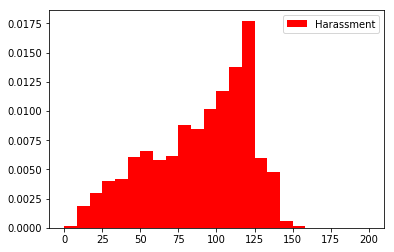

In [30]:
bins_ = np.linspace(0, 200, 25)

#Harassment plot
plt.hist(H_tweet_1, bins= bins_, normed=True, alpha = 1, color='red', label = 'Harassment');
plt.legend();

/Users/randy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


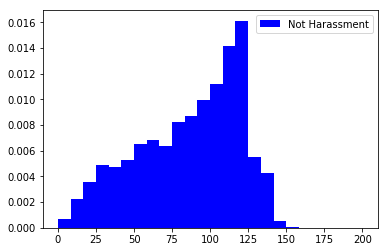

In [31]:
#not harassment plot
plt.hist(NH_tweet_0, bins= bins_, normed=True, alpha = 1, color='blue', label = 'Not Harassment');
plt.legend();

In [43]:
#put dataframe into a pickle for later use
pickle.dump(data, open( "save.p", "wb" ) )